In [1]:
import mne
import autoreject #version 0.3.1 https://autoreject.github.io/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subj_num = '0023'
subj_num_alt = ''.join([x for x in subj_num if x != '0'])#subj num coded diffferently for epohcs

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Importing raw data to create mne's info structure

In [2]:
raw = mne.io.read_raw_brainvision("/media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/eeg4/MD3-%s.vhdr"%subj_num, preload =False)
raw.set_channel_types({'EOGh':'eog','EOGv':'eog', 'A1':'misc', 'A2':'misc'})#declare type to avoid confusion with EEG channels
raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})#Naming convention
raw.set_montage('standard_1020')#Standard 1020 electrode montage
raw.rename_channels({'Fp1':'FP1', 'Fp2':'FP2'})
#raw.plot_sensors(ch_type='eeg')

Extracting parameters from /media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/eeg4/MD3-0023.vhdr...
Setting channel info structure...


/tmp/ipykernel_148826/1277617053.py:4: RuntimeWarning: Not setting positions of 2 misc channels found in montage:
['A1', 'A2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw.set_montage('standard_1020')#Standard 1020 electrode montage


<RawBrainVision | MD3-0023.eeg, 34 x 1272832 (2545.7 s), ~52 kB, data not loaded>

## Loading epochs

Not setting metadata
200 matching events found
No baseline correction applied
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


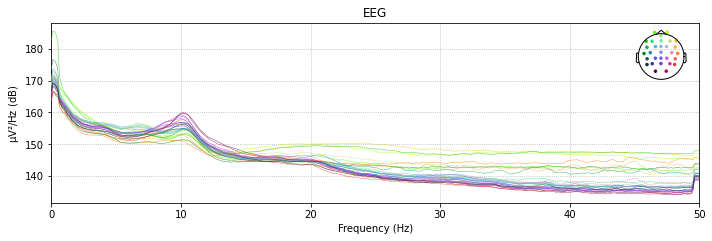

In [3]:
epochs = mne.io.read_epochs_fieldtrip("/media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/data%s.mat"%subj_num_alt, info=raw.info)
%matplotlib inline
epochs.plot_psd(fmax=50);

## Filtering, cropping, apply baseling resample and re-reference the epochs

In [4]:
epochs.filter(1,35)#same badwidth filter as van Maanen, Portoles & Borst (2021)
epochs.crop(tmin=-.250)
epochs.resample(100)
epochs.set_eeg_reference('average')
%matplotlib qt
epochs.plot(block=True, n_channels=32, scalings=100);#Marking bad electrodes

Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 1651 samples (3.302 sec)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.
Opening epochs-browser...
Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


## Applying ICA

In [5]:
ica = mne.preprocessing.ICA(n_components = 30-len(epochs.info["bads"])-1)# -1 for rank deficiency due to average ref
ica.fit(epochs, reject_by_annotation=True)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 29 components
Fitting ICA took 6.9s.


Method,fastica
Fit,45 iterations on epochs (65000 samples)
ICA components,29
Explained variance,100.0 %
Available PCA components,30
Channel types,eeg
ICA components marked for exclusion,—


In [7]:
%matplotlib qt

ica.plot_components(inst=epochs)

[<MNEFigure size 702x696 with 20 Axes>, <MNEFigure size 702x357 with 9 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


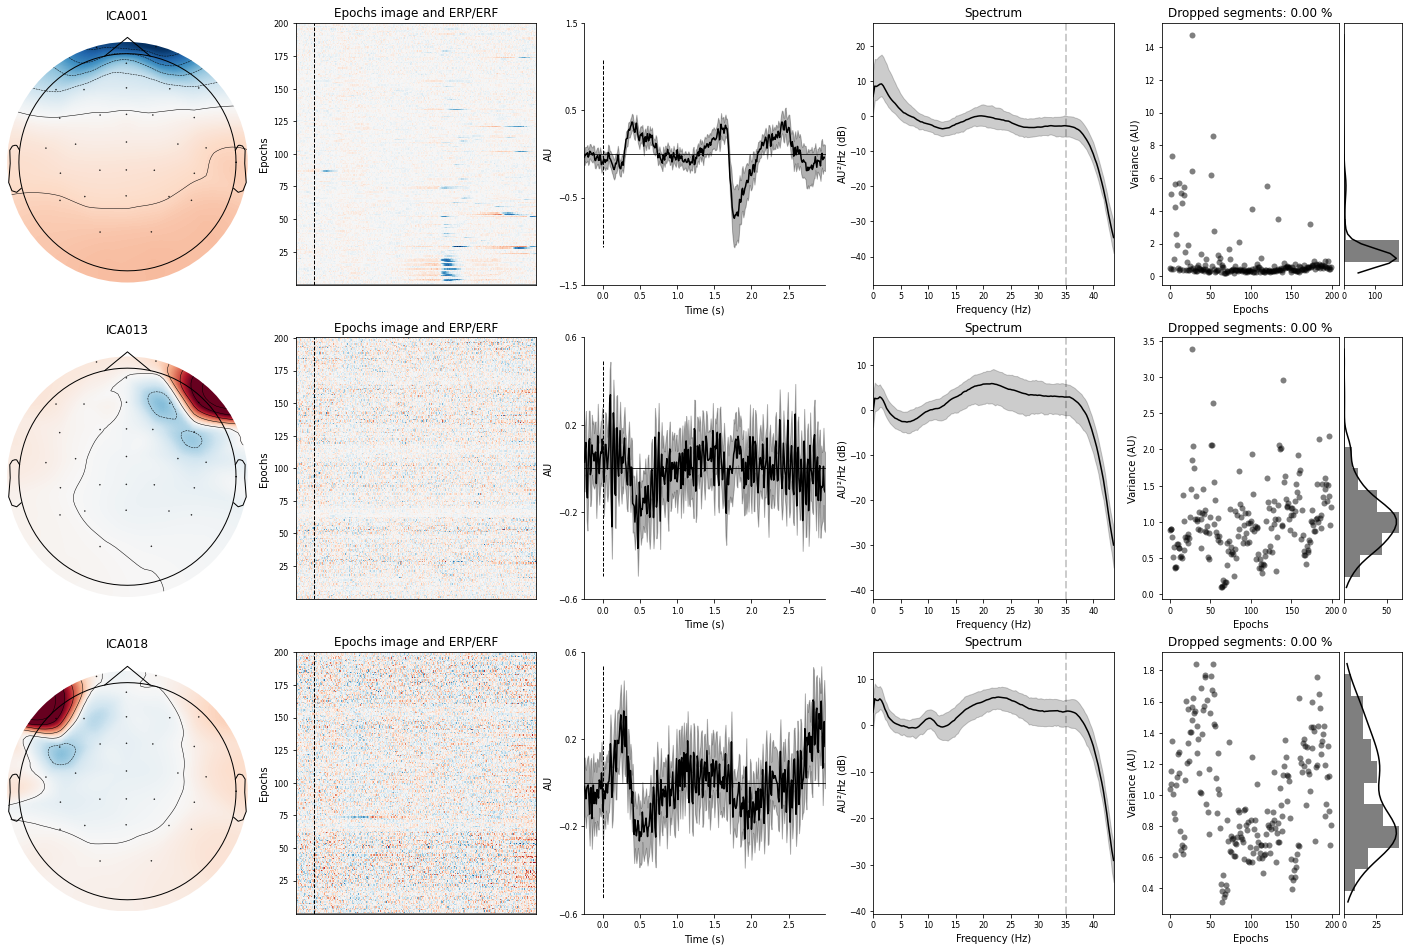

In [8]:
%matplotlib inline 
n_comp = len(ica.exclude)
fig, ax = plt.subplots(n_comp, 5, figsize = (25, len(ica.exclude)*5))
i = 0
for comp in ica.exclude:
    if n_comp >1:
        ica.plot_properties(epochs, picks=comp, axes=ax[i,:], show=False);
    else:
        ica.plot_properties(epochs, picks=comp, axes=ax[:], show=False);
    i += 1
plt.show()

## Applying ICA

[1, 13, 18]
Applying ICA to Evoked instance
    Transforming to ICA space (29 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


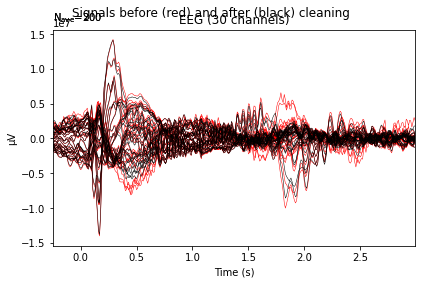

In [9]:
%matplotlib inline 
print(ica.exclude)
ica.plot_overlay(epochs.average(), exclude=ica.exclude, picks='eeg');

In [10]:
ica.apply(epochs)


Applying ICA to Epochs instance
    Transforming to ICA space (29 components)
    Zeroing out 3 ICA components
    Projecting back using 30 PCA components


Number of events,200
Events,1: 200
Time range,-0.250 – 2.990 sec
Baseline,off


### Interpolate (eventual) bad electrodes

Applying baseline correction (mode: mean)
    Using multitaper spectrum estimation with 7 DPSS windows


/tmp/ipykernel_148826/2972015899.py:1: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads()


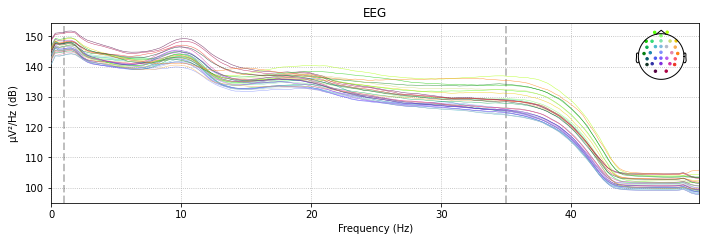

In [11]:
epochs.interpolate_bads()
epochs.pick_types(eeg=True)
epochs.apply_baseline(baseline=(None, 0))
%matplotlib inline
epochs.plot_psd(fmax=50);

## Rejecting bad epochs

In [12]:
%matplotlib inline

ar = autoreject.AutoReject(consensus=np.linspace(0, .4, 10), n_interpolate = np.arange(1,round(len(epochs.ch_names)/5)), n_jobs=-1) #I constrain the consensus parameter to be <=.4 as trials with almost half bad chan should be rejected
ar.fit(epochs)  # fit on the first 20 epochs to save time
epochs_ar, reject_log = ar.transform(epochs, return_log=True)

Running autoreject on ch_type=eeg


  0%|          | Creating augmented epochs : 0/30 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/30 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/5 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.40 and n_interpolate=1


  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

Dropped 7 epochs: 28, 83, 99, 139, 172, 187, 195


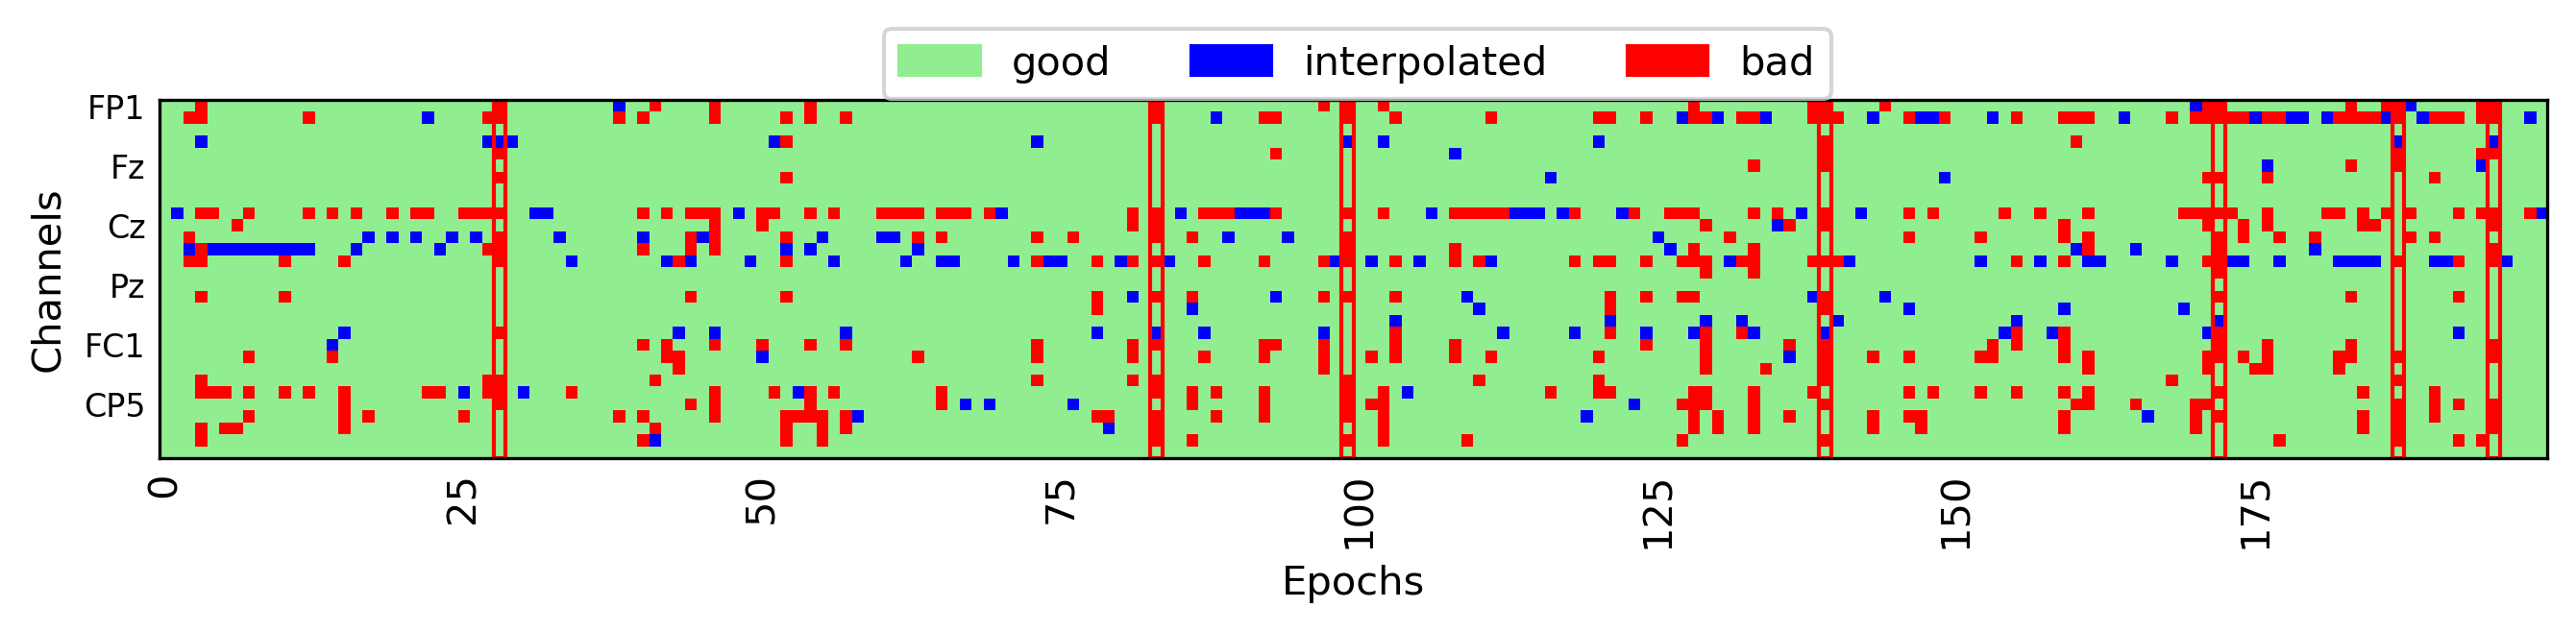

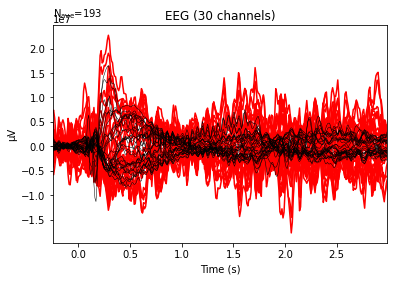

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1,1, figsize=(10,20), dpi=300)
reject_log.plot('horizontal', ax=ax)
plt.show()
evoked_bad = epochs[reject_log.bad_epochs].average()
plt.figure()
plt.plot(evoked_bad.times, evoked_bad.data.T * 1e6, 'r', zorder=-1)
epochs_ar.average().plot(axes=plt.gca());

Opening epochs-browser...


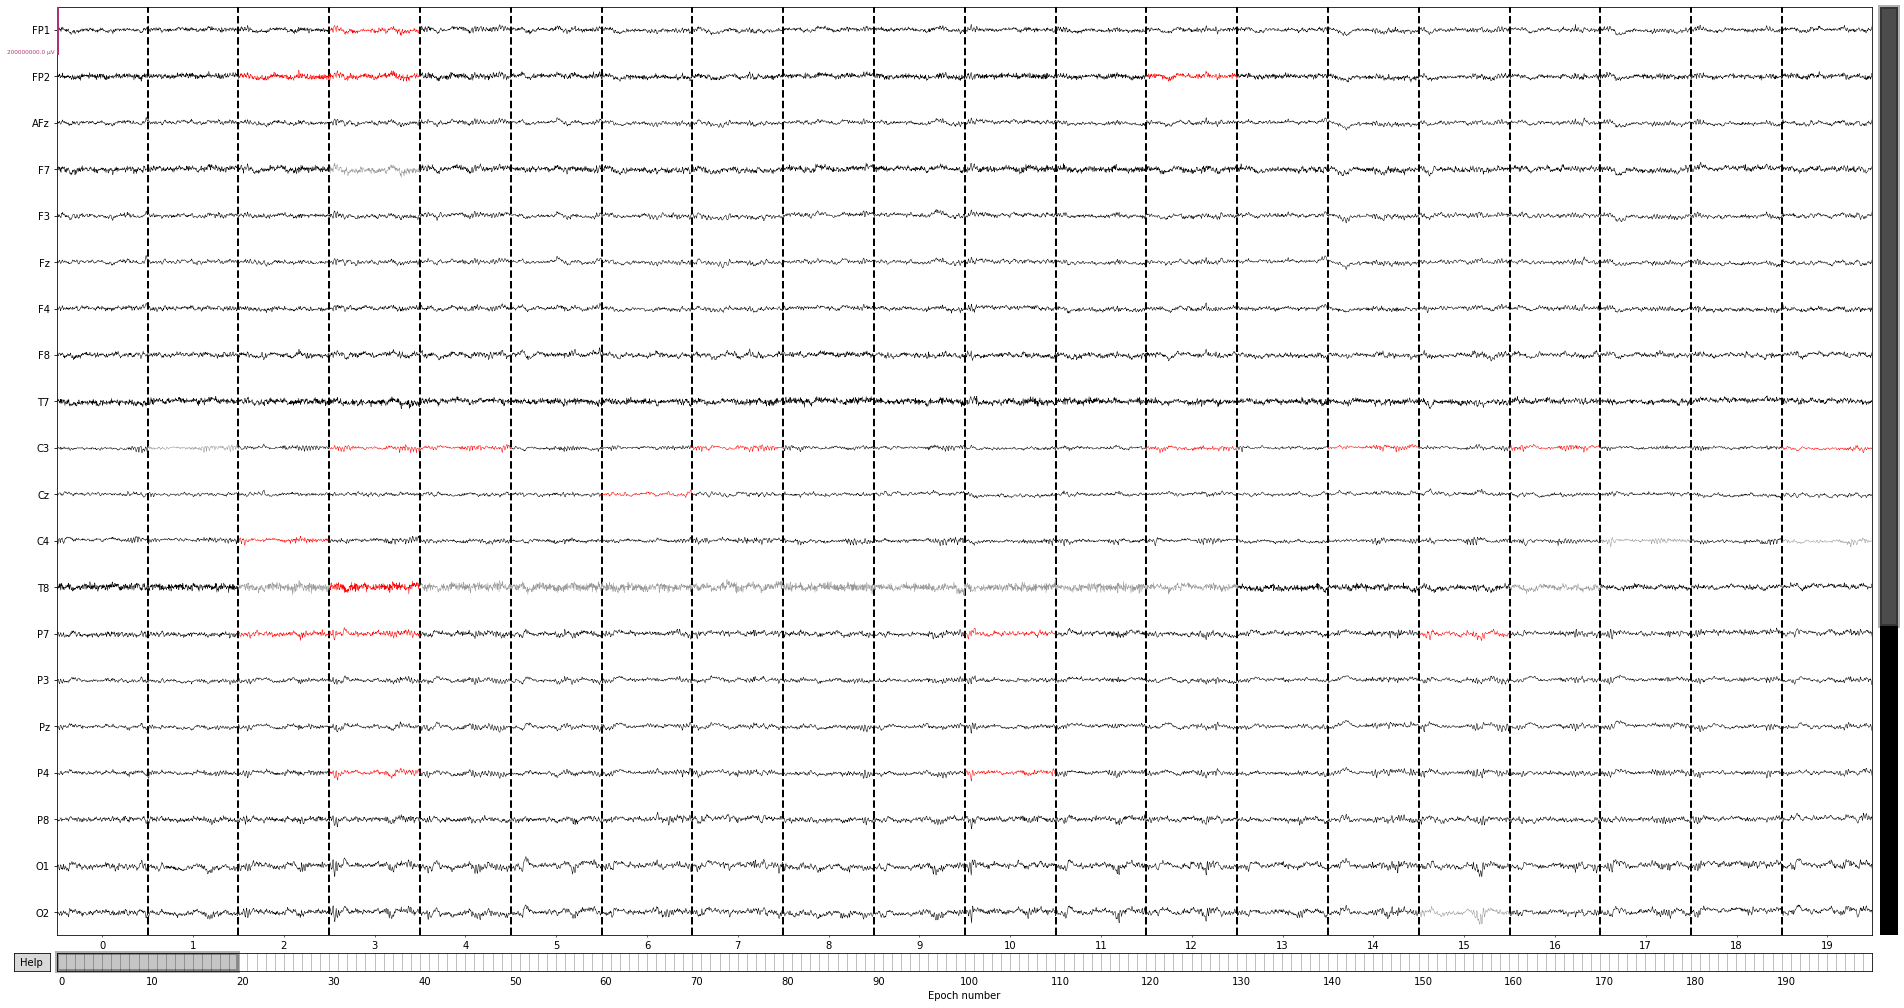

Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [14]:
%matplotlib qt
reject_log.plot_epochs(epochs,scalings=dict(eeg=100))

  0%|          | Repairing epochs : 0/200 [00:00<?,       ?it/s]

Dropped 7 epochs: 28, 83, 99, 139, 172, 187, 195


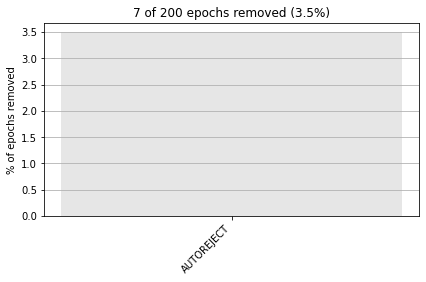

In [15]:
epochs_ar, reject_log = ar.transform(epochs, return_log=True)
%matplotlib inline
epochs_ar.plot_drop_log();

In [16]:
epochs_ar.to_data_frame().to_csv('%s.csv'%subj_num)#Saving csv
epochs_ar.save('%s_epo.fif'%subj_num, overwrite=True)#Saving EEG mne format

## EDIT 2023 add metadata

Reading /media/gweindel/2563485E45D6BE9E1/EEG_data/Boehm_CNV/notebooks_and_fif_data/0023_epo.fif ...
    Found the data of interest:
        t =    -250.00 ...    2990.00 ms
        0 CTF compensation matrices available
Not setting metadata
193 matching events found
No baseline correction applied
0 projection items activated


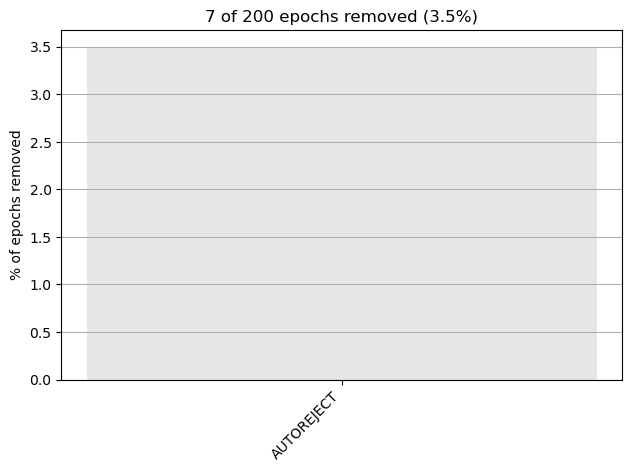

     stim        resp    RT cue    movement                   trigger
0       1   resp_left  1576  AC   stim_left    AC/stim_left/resp_left
1       1   resp_left   596  SP   stim_left    SP/stim_left/resp_left
2       2   resp_left   782  SP  stim_right   SP/stim_right/resp_left
3       2   resp_left  1342  AC  stim_right   AC/stim_right/resp_left
4       1   resp_left   587  SP   stim_left    SP/stim_left/resp_left
..    ...         ...   ...  ..         ...                       ...
195     1  resp_right  1103  AC   stim_left   AC/stim_left/resp_right
196     2  resp_right   321  SP  stim_right  SP/stim_right/resp_right
197     2   resp_left   434  SP  stim_right   SP/stim_right/resp_left
198     1   resp_left   386  SP   stim_left    SP/stim_left/resp_left
199     2  resp_right  1277  AC  stim_right  AC/stim_right/resp_right

[200 rows x 6 columns]
Adding metadata with 6 columns


In [2]:
import os 

epochs_ar = mne.read_epochs('%s_epo.fif'%subj_num, preload=True)
epochs_ar.plot_drop_log()

behavioral_data_path = os.path.join('../ExperimentData/ExperimentData/')#Declaring path where the eeg data is

#First we read the behavioral data, the name of the colums is at the end of the next line and will depend on your experiment
behavior = pd.read_csv(os.path.join(behavioral_data_path+'%s-cnv-sat3_ET.csv'%subj_num), sep=';')[['stim', 'resp', 'RT','cue', 'movement',]]
#Next we need to store the infos of the RT and experimental conditions for each recorded epochs
#(optional) we can rename the varaiable that are numerically coded, this does make your code more transparent for others
behavior['movement'] = behavior.apply(lambda row: 'stim_left' if row['movement'] == -1 else 
                                  ('stim_right' if row['movement'] == 1 else np.nan), axis=1)
behavior['resp'] = behavior.apply(lambda row: 'resp_left' if row['resp'] == 1 else 
                                  ('resp_right' if row['resp'] == 2 else np.nan ), axis=1)
#Merging together the exeperimental conditions info to have the format condition/stimulus/response
behavior['trigger'] = behavior['cue'] + '/' +  behavior['movement'] + '/' +  behavior['resp']

#Next if you want some RTs not to be analyzed (e.g. less than 300 ms because unrealistically fast) you should do this by zeroing out outliers RTs
behavior['RT'] = behavior.apply(lambda row: 0 if row['RT'] < 300 else (
            0 if row['RT'] > 3000 else row['RT']), axis = 1)
print(behavior)
valid_epoch_index = [x for x,y in enumerate(epochs_ar.drop_log) if len(y) == 0]
epochs_ar.metadata = behavior.iloc[valid_epoch_index]
epochs_ar.save('processed_%s_2023_epo.fif'%subj_num, overwrite=True)#Saving EEG mne format